In [1]:
import folium
import numpy as np
import pandas as pd
import requests
import json
import os
import time
import imageio
import branca
import heapq

import matplotlib.pyplot as plt

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
csv = pd.read_csv('second_add_velocity_degree.csv')
print(csv.__len__())
csv.head()

8577


,created_time,Lantitute,Longitude,velocity,degree
0,'2023-07-16 00:00:59.682',22.338088,114.124317,1.6,71.3
1,'2023-07-16 00:01:59.685',22.338162,114.124578,0.6,80.4
2,'2023-07-16 00:02:59.671',22.338195,114.124750,0.5,81.0
3,'2023-07-16 00:03:59.658',22.338277,114.124875,0.5,54.6
4,'2023-07-16 00:04:59.810',22.338380,114.124975,0.5,42.2


In [3]:
def draw_grid(map_object, start_lat, end_lat, start_lon, end_lon, delta=0.1):

    # 위도에 대한 격자 그리기
    lat_list = list(np.arange(start_lat, end_lat+delta, delta))
    for lat in lat_list:
        folium.PolyLine([(lat, start_lon), (lat, end_lon)], color="black", weight=0.5, opacity=1).add_to(map_object)

    # 경도에 대한 격자 그리기
    lon_list = list(np.arange(start_lon, end_lon+delta, delta))
    for lon in lon_list:
        folium.PolyLine([(start_lat, lon), (end_lat, lon)], color="black", weight=0.5, opacity=1).add_to(map_object)
    
    return map_object

FIN
(5, 28) (30, 58)
FIN
(22, 51) (30, 58)
FIN
(26, 54) (30, 58)
FIN
(29, 58) (30, 58)


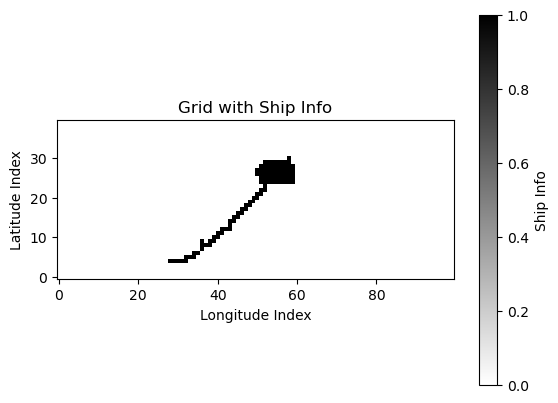

In [7]:
def draw_path_way_html(bins):
    m = folium.Map(location=[32.09, 126.965], zoom_start=6)
    draw_grid(m, 20, 40, 100, 150, delta=0.5)

    folium.PolyLine(locations[:bins], color="red", weight=3, opacity=1).add_to(m)
    m.save(f"./second/basic_path_way/{bins}.html")
    

def download_file(file_url):
    response = requests.get(file_url) # 파일 URL에 GET 요청 보내기
    return json.loads(response.content.decode('utf-8'))["result"]["data"]    
    
def request_urls(date):
    personal_key = "n9lzvAEoGIkpCIKQa4mbGg=="
    # url = f"http://www.khoa.go.kr/api/oceangrid/DataType/search.do?ServiceKey={personal_key}&ObsCode={obseving}&Date={date}&ResultType=json"
    url1 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=KG_0021&Date={date}&ResultType=json"
    data_dict1 = download_file(url1)    

    url2 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=KG_0028&Date={date}&ResultType=json"
    data_dict2 = download_file(url2)    

    url3 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=TW_0075&Date={date}&ResultType=json"
    data_dict3 = download_file(url3)    

    url4 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=TW_0080&Date={date}&ResultType=json"
    data_dict4 = download_file(url4)   

    url5 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=HB_0002&Date={date}&ResultType=json"
    data_dict5 = download_file(url5)   

    url6 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=KG_0102&Date={date}&ResultType=json"
    data_dict6 = download_file(url6) 

    url7 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=TW_0095&Date={date}&ResultType=json"
    data_dict7 = download_file(url7) 

    url8 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=KG_0024&Date={date}&ResultType=json"
    data_dict8 = download_file(url8) 

    url9 = f"http://www.khoa.go.kr/api/oceangrid/tidalBuWind/search.do?ServiceKey={personal_key}&ObsCode=KG_0025&Date={date}&ResultType=json"
    data_dict9 = download_file(url9)  # 남해동부
    
    return data_dict1, data_dict2, data_dict3, data_dict4, data_dict5, data_dict6, data_dict7, data_dict8, data_dict9


def compute_location(lat, lon, distance, bearing):
    R = 6371.0
    bearing_rad = np.radians(bearing)
    lat1 = np.radians(lat)
    lon1 = np.radians(lon)
    lat2 = np.arcsin(np.sin(lat1) * np.cos(distance/R) + np.cos(lat1) * np.sin(distance/R) * np.cos(bearing_rad))
    lon2 = lon1 + np.arctan2(np.sin(bearing_rad) * np.sin(distance/R) * np.cos(lat1), np.cos(distance/R) - np.sin(lat1) * np.sin(lat2))
    return np.degrees(lat2), np.degrees(lon2)

def find_closest_grid_center(lat, lon, lat_list, lon_list, delta=0.5):
    closest_lat = min(lat_list, key=lambda x: abs(x - lat))
    closest_lon = min(lon_list, key=lambda x: abs(x - lon))
    
    # 격자의 중심 좌표를 찾기 위해 델타의 절반을 더해줍니다.
    center_lat = closest_lat + (delta / 2)
    center_lon = closest_lon + (delta / 2)
    
    lat_index = lat_list.index(closest_lat)
    lon_index = lon_list.index(closest_lon)
    
    return center_lat, center_lon, lat_index, lon_index
    
def initialize_matrix(rows, cols):
    return [[{ "wind_speed": None, "angle": None, "velocity": None, "degree": None} for _ in range(cols)] for _ in range(rows)]

def matrix_to_numpy(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    # 0과 1로 구성된 numpy 배열 생성: 0은 배 정보가 없음, 1은 배 정보가 있음
    np_matrix = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            if matrix[i][j]["velocity"]:
                np_matrix[i][j] = 1
    
    return np_matrix

def visualize_numpy(np_matrix):
    plt.imshow(np_matrix, cmap='gray_r', origin='lower') # 'gray_r' colormap은 1을 흰색으로, 0을 검은색으로 표시
    plt.colorbar(label='Ship Info')
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.title('Grid with Ship Info')
    plt.show()
    
def draw_arrows_on_grid(map_object, matrix, record, rec1_lat, rec1_lon, row, col, delta=0.5, a_color = "blue"):
    start_lat, end_lat = 20, 40
    start_lon, end_lon = 100, 150

    lat_list = list(np.arange(start_lat, end_lat, delta))
    lon_list = list(np.arange(start_lon, end_lon, delta))

    base_lat, base_lon, lat_index, lon_index = find_closest_grid_center(rec1_lat, rec1_lon, lat_list, lon_list, delta)    
    wind_dir = float(record["wind_dir"])
    wind_speed = float(record["wind_speed"])
    angle = (90 - wind_dir) % 360
    

    for r in range(row[0], row[1]+1):
        for c in range(col[0], col[1]+1):
            current_lat = base_lat - (r * delta)
            current_lon = base_lon - (c * delta)
            
            end_lat, end_lon = compute_location(current_lat, current_lon, wind_speed * 3, angle)

            # 화살표 머리의 위치 계산
            arrow_length = 5
            arrow_left = compute_location(end_lat, end_lon, arrow_length, angle + 135)
            arrow_right = compute_location(end_lat, end_lon, arrow_length, angle - 135)

            folium.PolyLine([(current_lat, current_lon), (end_lat, end_lon)], color=a_color).add_to(map_object)
            folium.PolyLine([(end_lat, end_lon), arrow_left, arrow_right, (end_lat, end_lon)], color=a_color).add_to(map_object)
            
            matrix[lat_index+r][lon_index+c]["wind_speed"] = wind_speed
            matrix[lat_index+r][lon_index+c]["angle"] = angle
    return map_object, matrix

def check_ship_in_grid(matrix, ship_path, ship_vel_deg, start_lat, end_lat, start_lon, end_lon, delta=0.5):
    lat_list = list(np.arange(start_lat, end_lat, delta))
    lon_list = list(np.arange(start_lon, end_lon, delta))
    
    for i, lat in enumerate(lat_list[:-1]):
        for j, lon in enumerate(lon_list[:-1]):
            top_left = (lat, lon)
            bottom_right = (lat + delta, lon + delta)
            for point, (velocity, degree) in zip(ship_path, ship_vel_deg):
                if top_left[0] <= point[0] <= bottom_right[0] and top_left[1] <= point[1] <= bottom_right[1]:
                    matrix[i][j]["velocity"] = velocity
                    matrix[i][j]["degree"] = degree
                    break
    return matrix


def compute_dot_product(matrix):
    dot_product_matrix = np.zeros((len(matrix), len(matrix[0])))

    for i, row in enumerate(matrix):
        for j, cell in enumerate(row):
            if cell["wind_speed"] and cell["angle"]:
                # 바람 벡터 생성
                wind_vector = np.array([
                    np.cos(np.radians(cell["angle"])), 
                    np.sin(np.radians(cell["angle"]))
                ])
                
                if not cell["velocity"] or not cell["degree"]:
                    # 해당 cell에서 가장 가까운 배의 정보 찾기
                    closest_ship_info = None
                    min_distance = float('inf')
                    for potential_cell in row:
                        if potential_cell["velocity"] and potential_cell["degree"]:
                            distance = abs(i - row.index(potential_cell))
                            if distance < min_distance:
                                min_distance = distance
                                closest_ship_info = potential_cell

                    if closest_ship_info:
                        cell["velocity"] = closest_ship_info["velocity"]
                        cell["degree"] = closest_ship_info["degree"]
                    else:
                        continue

                # 배의 이동 방향을 방위각으로 변환
                # bearing = (360 - cell["degree"]) % 360
                bearing = cell['degree']%360

                # 배 벡터 생성
                ship_vector = np.array([
                    np.cos(np.radians(bearing)), 
                    np.sin(np.radians(bearing))
                ])
                
                # dot-product 계산
                dot_product = np.dot(wind_vector, ship_vector)
                
                dot_product_matrix[i][j] = dot_product
                
    return dot_product_matrix

def scale_and_colormap(matrix):
    # 각 항목의 값을 리스트에 저장
    values = [[item if item else 0 for item in row] for row in matrix]
    
    # 스케일링을 위한 최소값과 최대값 계산 (0은 제외)
    non_zero_values = [v for sublist in values for v in sublist if v != 0]
    min_val, max_val = np.min(non_zero_values), np.max(non_zero_values)
    
    # 0은 그대로, 음수나 양수는 스케일링 진행
    normalized_values = np.array(values)
    mask = normalized_values != 0
    normalized_values[mask] = (normalized_values[mask] - min_val) / (max_val - min_val)
    
    # 10단계로 나누기
    binned_values = (normalized_values * 10).astype(int)

    # colormap 생성 (점수가 높을수록 화려한 색)
    colormap = branca.colormap.linear.YlOrRd_09.scale(0, 10)
    # reversed_colors = list(reversed(colormap.colors))
    # colormap.colors = reversed_colors

    return binned_values, colormap

def draw_colored_grid(map_object, matrix, colormap, start_lat, end_lat, start_lon, end_lon, delta=0.1):
    # 격자 색칠하기
    lat_list = list(np.arange(start_lat, end_lat, delta))
    lon_list = list(np.arange(start_lon, end_lon, delta))

    for i in range(len(lat_list)-1):
        for j in range(len(lon_list)-1):
            if matrix[i][j] == 0:  # 0인 부분은 생략
                continue

            top_left = (lat_list[i], lon_list[j])
            bottom_right = (lat_list[i+1], lon_list[j+1])
            color = colormap(matrix[i][j])

            folium.Rectangle(
                bounds=[top_left, bottom_right],
                color=color,
                fill_color=color,
                fill_opacity=0.5  # 투명도를 0.5로 설정
            ).add_to(map_object)
    
    # 스펙트럼 추가
    colormap.caption = 'Dot-Product Score'
    colormap.add_to(map_object)

    return map_object

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

def a_star_search(matrix, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for (i, j) in [(0,1), (1,0), (0,-1), (-1,0), (1,1), (-1,-1), (1,-1), (-1,1)]: # 인접한 8개의 셀
            next_cell = (current[0] + i, current[1] + j)
            
            if 0 <= next_cell[0] < len(matrix) and 0 <= next_cell[1] < len(matrix[0]):
                new_cost = cost_so_far[current] + 10 - matrix[next_cell[0]][next_cell[1]]
                if next_cell not in cost_so_far or new_cost < cost_so_far[next_cell]:
                    cost_so_far[next_cell] = new_cost
                    priority = new_cost + heuristic(goal, next_cell)
                    frontier.put(next_cell, priority)
                    came_from[next_cell] = current
                    
    # 경로 반환
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path


def find_nearest_grid_corner(lat, lon, start_lat, start_lon, grid_lat_size, grid_lon_size):
    grid_lat = start_lat + (int((lat - start_lat) / grid_lat_size) * grid_lat_size)
    grid_lon = start_lon + (int((lon - start_lon) / grid_lon_size) * grid_lon_size)
    return grid_lat, grid_lon

def draw_path_on_map(map_object, path, start_lat, end_lat, start_lon, end_lon, delta=0.1):
    lat_list = list(np.arange(start_lat, end_lat, delta))
    lon_list = list(np.arange(start_lon, end_lon, delta))
    
    path_coords = [(lat_list[x], lon_list[y]) for (x, y) in path]

    folium.PolyLine(path_coords, color="blue", weight=3, opacity=1).add_to(map_object)
    return map_object


personal_key = "n9lzvAEoGIkpCIKQa4mbGg==" # 인증키
bins = [1, 6100, 6500, 6900]

locations = csv[['Lantitute', 'Longitude']].values.tolist()
ship_vel_deg = csv[['velocity', 'degree']].values.tolist()
mid_lat = (csv['Lantitute'].max() + csv['Lantitute'].min()) / 2
mid_lon = (csv['Longitude'].max() + csv['Longitude'].min()) / 2

for b in bins: 
    draw_path_way_html(b)
    
    date = csv.iloc[b+100]["created_time"]
    formatted_dates = date[1:5] + date[6:8] + date[9:11]
    s = request_urls(formatted_dates)
    new_li = []
    for i in range(s.__len__()):
        new_li.append(s[i][int(date[12:14])])
        
    matrix = initialize_matrix((40-20)*2, (150-100)*2)
    m = folium.Map(location=[32.09, 126.965], zoom_start=6)
    draw_grid(m, 20, 40, 100, 150, delta=0.5)
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[0], 32.09,  126.965,  row = [0, 4], col = [-3, 5], delta=0.5, a_color = "blue") # 제주 아래 아래
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[1], 33.7,   126.59,   row = [-1, 0], col = [-2, 4], delta=0.5, a_color = "blue") # 제주 위
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[2], 33.234, 126.409,  row = [0, 1], col = [-3, 4], delta=0.5,  a_color = "blue") # 제주 아래
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[3], 34.543, 125.802,  row = [-2, 0], col = [0, 3], delta=0.5, a_color = "blue") # 서해안, 전남
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[4], 35.318, 129.314,  row = [0, 3], col = [-2, 0], delta=0.5, a_color = "blue") # 부산 울산
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[5], 37.742, 130.601,  row = [-3, 0], col = [-2, 2], delta=0.5, a_color = "blue") # 울릉도 위
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[6], 36.58,  129.454,  row = [-1, 1], col = [-2, 0], delta=0.5, a_color = "blue") # 울릉도 아래
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[7], 34.919, 129.121,  row = [0, 0], col = [0, 0], delta=0.5, a_color = "blue")   # 부산
    m, matrix = draw_arrows_on_grid(m, matrix, new_li[8], 34.222, 128.419,  row = [-1, 1], col = [-1, 1], delta=0.5, a_color = "blue") # 부산 아래
    
    folium.PolyLine(locations[:b], color="red", weight=3, opacity=1).add_to(m)
    folium.PolyLine(locations[b:], color="red", weight=3, opacity=1, dash_array="5, 10").add_to(m)

    matrix = check_ship_in_grid(matrix, locations, ship_vel_deg, 20, 40, 100, 150)


    m.save(f"./second/grid_with_arrows_map_{b}.html")
    print("FIN")
    
    # Example usage:
    m = folium.Map(location=[32.09, 126.965], zoom_start=6)
    draw_grid(m, 20, 40, 100, 150, delta=0.5)
    dot_product_matrix = compute_dot_product(matrix)
    binned_matrix, colormap = scale_and_colormap(dot_product_matrix)

    m = draw_colored_grid(m, binned_matrix, colormap, 20, 40, 100, 150, delta=0.5)
    folium.PolyLine(locations[:b], color="red", weight=3, opacity=1).add_to(m)
    folium.PolyLine(locations[b:], color="red", weight=3, opacity=1, dash_array="5, 10").add_to(m)

    m.save(f"./second/grid_with_arrows_map_color_{b}.html")
    

    start_lat, end_lat = 20, 40
    start_lon, end_lon = 100, 150

    lat_list = list(np.arange(start_lat, end_lat, 0.5))
    lon_list = list(np.arange(start_lon, end_lon, 0.5))
    
    _, _, lat_index, lon_index = find_closest_grid_center(locations[b][0], locations[b][1], lat_list, lon_list, delta=0.5)


    start = (lat_index, lon_index) # 예시 시작 지점
    goal =  (30,58) # 예시 목표 지점
    print(start, goal)
    
    # Example usage:
    m = folium.Map(location=[32.09, 126.965], zoom_start=6)
    draw_grid(m, 20, 40, 100, 150, delta=0.5)
    m = draw_colored_grid(m, binned_matrix, colormap, 20, 40, 100, 150, delta=0.5)
    # A* 경로 계산 및 그리기
    path = a_star_search(binned_matrix, start, goal)
    m = draw_path_on_map(m, path, 20, 40, 100, 150, delta=0.5)
    folium.PolyLine(locations[:b], color="red", weight=3, opacity=1).add_to(m)
    folium.PolyLine(locations[b:], color="red", weight=3, opacity=1, dash_array="5, 10").add_to(m)
    m.save(f"./second/colored_grid_map_with_path_{b}.html")

np_matrix = matrix_to_numpy(matrix)
visualize_numpy(np_matrix)